## Librerías

*Keras*

In [110]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPool2D, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import gzip

*Sklearn*

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

*Datos + Viz*

In [112]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from matplotlib import image as mpimage

In [113]:
from PIL import Image
import os

## Ficheros

In [114]:
calc_train = pd.read_csv('../../artifacts/data/calc_case_description_train_set.csv')
calc_test = pd.read_csv('../../artifacts/data/calc_case_description_test_set.csv')
mass_train = pd.read_csv('../../artifacts/data/mass_case_description_train_set.csv')
mass_test = pd.read_csv('../../artifacts/data/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('../../artifacts/data/dicom_info.csv')

In [115]:
calc_train.head(1)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...


In [116]:
len(calc_train)

1546

In [117]:
dicom_df.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


### Filtrado y limpieza de imágenes

### Rutas

Las rutas correctas a la imágenes están en el fichero Dicom. Por ello, hay que obtener las rutas correctas de dicom, y después aplicarlas al resto de ficheros de test y entrenamiento

In [118]:
#función para reemplazar rutas:

def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [119]:
# def plot_smaples(sample, row=15, col=15):
#     plt.figure(figsize=(row, col))
#     for i, file in enumerate(sample[0:5]):
#         cropped_images_show = PIL.Image.open(file)
#         gray_img= cropped_images_show.convert("L")
#         plt.subplot(1,5,i+1)
#         plt.imshow(gray_img, cmap='gray')
#         plt.axis('off')
#     plt.show()

# obtener las rutas de dicom: Se filtra para los tres tipos de imágenes y se guardan en series
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

#Ruta correcta
correct_dir = "C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg"

# Reemplazar ruta para cropped_images
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) #comprobar ruta


# Reemplazar ruta para full_mammogram .
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0])  #comprobar ruta

# Reemplazar ruta para roi_mask
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])  #comprobar ruta

Cropped Images paths:
C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [120]:
# Se crean diccionarios donde:
# - La clave es una parte del nombre del archivo extraída de la ruta (el elemento en la posición [10] al hacer .split('/')).
# - El valor es la ruta completa.

def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[10]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [121]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


In [122]:
# Extraer una parte del nombre de imagen desde las columnas 11, 12 y 13 (que contienen rutas)
# Usar *_dict para buscar la ruta real y correcta de la imagen
# Sustituir la ruta en el DataFrame
# Si no encuentra la imagen en el diccionario, poner None

def fix_image_path(data):
    """modifica rutas dicom a las imagenes correctas"""
    for indx, image in enumerate(data.values):

        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 12] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

In [123]:
fix_image_path(mass_train)
fix_image_path(mass_test)
fix_image_path(calc_train)
fix_image_path(calc_test)

In [124]:
#Verificar que las rutas se han modificado correctamente:

def check_image_paths(df, name='DataFrame', cols=['image file path', 'cropped image file path', 'ROI mask file path'], n=3):
    print(f"\n🔍 Verificando {name}")
    for col in cols:
        print(f"\n📂 Columna: {col}")
        for i, path in enumerate(df[col].head(n)):
            print(f"[{i}] Ruta: {path}")
            if path and os.path.exists(path):
                try:
                    img = Image.open(path)
                    img.verify()  # Solo comprueba que es una imagen válida
                    print(f"✅ Imagen válida.")
                except Exception as e:
                    print(f"❌ Error al abrir la imagen: {e}")
            else:
                print("❌ Ruta vacía o no existe.")


check_image_paths(mass_train, name='mass_train')
check_image_paths(mass_test, name='mass_test')
check_image_paths(calc_train, name='calc_train')
check_image_paths(calc_test, name='calc_test')



🔍 Verificando mass_train

📂 Columna: image file path
[0] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg
✅ Imagen válida.
[1] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg
✅ Imagen válida.
[2] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg
✅ Imagen válida.

📂 Columna: cropped image file path
[0] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg
✅ Imagen válida.
[1] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg
✅ Imagen válida.
[2] Ruta: C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850

Faltan algunas imágenes al menos de calc_test. Verificar posteriormente

## Análisis del dataset

### Revisión general:

In [125]:
print("Calc Train shape:", calc_train.shape)
print("Calc Test shape:", calc_test.shape)
print("Mass Train shape:", mass_train.shape)
print("Mass Test shape:", mass_test.shape)

print("\nCalc Train columns:")
print(calc_train.columns)

print("\nMass Train columns:")
print(mass_train.columns)


Calc Train shape: (1546, 14)
Calc Test shape: (326, 14)
Mass Train shape: (1318, 14)
Mass Test shape: (378, 14)

Calc Train columns:
Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

Mass Train columns:
Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')


Unir train y test:

In [126]:
calc = pd.concat([calc_train, calc_test], ignore_index=True)
mass = pd.concat([mass_train, mass_test], ignore_index=True)

Corregir nombres de las columnas

In [127]:
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()  # elimina espacios al inicio y fin
        .str.lower()  # todo en minúsculas
        .str.replace(' ', '_')  # espacios por guiones bajos
    )
    return df


calc = clean_column_names(calc)
mass = clean_column_names(mass)

In [128]:
print("\nCalc columns:")
print(calc.columns)

print("\nMass columns:")
print(mass.columns)


Calc columns:
Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'calc_type', 'calc_distribution',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'roi_mask_file_path'],
      dtype='object')

Mass columns:
Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'roi_mask_file_path'],
      dtype='object')


### Análisis exploratorio:

In [129]:
print("Total casos de calcificación:", len(calc))
print("Total casos de masa:", len(mass))

Total casos de calcificación: 1872
Total casos de masa: 1696


In [130]:
#Distribución por BI-RADS (assesment): sistema de categorización del riesgo de cáncer de mama.

print("Distribución del BI-RADS (assessment) en calcificaciones:")
print(calc['assessment'].value_counts().sort_index())

print("\nDistribución del BI-RADS (assessment) en masas:")
print(mass['assessment'].value_counts().sort_index())

Distribución del BI-RADS (assessment) en calcificaciones:
assessment
0     76
2    553
3    113
4    931
5    199
Name: count, dtype: int64

Distribución del BI-RADS (assessment) en masas:
assessment
0    162
1      3
2     91
3    364
4    702
5    374
Name: count, dtype: int64


In [131]:
print("Calc_pathology:", calc['pathology'].unique())
print("Mass_pathology:", mass['pathology'].unique())

Calc_pathology: ['MALIGNANT' 'BENIGN' 'BENIGN_WITHOUT_CALLBACK']
Mass_pathology: ['MALIGNANT' 'BENIGN' 'BENIGN_WITHOUT_CALLBACK']


In [132]:
#Distribución por patología:
print(calc['pathology'].value_counts())
print(mass['pathology'].value_counts())


pathology
MALIGNANT                  673
BENIGN                     658
BENIGN_WITHOUT_CALLBACK    541
Name: count, dtype: int64
pathology
MALIGNANT                  784
BENIGN                     771
BENIGN_WITHOUT_CALLBACK    141
Name: count, dtype: int64


In [133]:
#Distribución por lateralidad de pecho:
print(calc['left_or_right_breast'].value_counts())
print(mass['left_or_right_breast'].value_counts())


left_or_right_breast
LEFT     1002
RIGHT     870
Name: count, dtype: int64
left_or_right_breast
RIGHT    879
LEFT     817
Name: count, dtype: int64


In [134]:
#Distribución por tipo de vista:
print(calc['image_view'].value_counts())
print(mass['image_view'].value_counts())


image_view
MLO    984
CC     888
Name: count, dtype: int64
image_view
MLO    912
CC     784
Name: count, dtype: int64


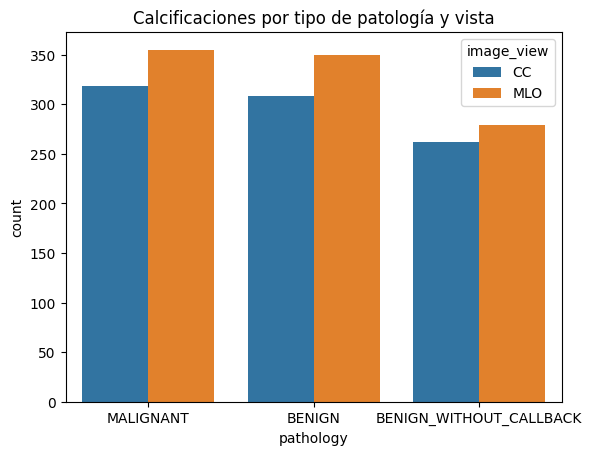

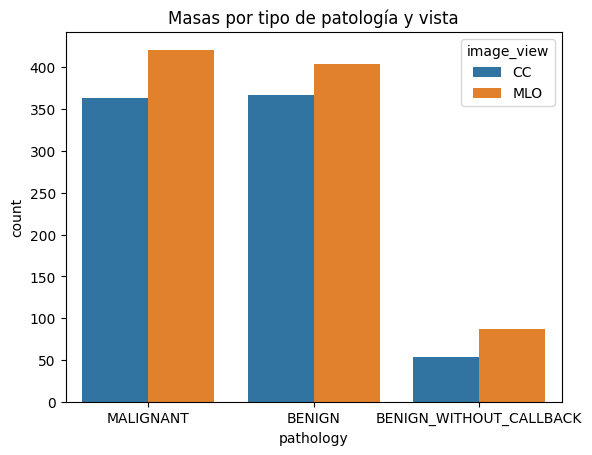

In [135]:
#Visualización vista-patología
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=calc, x='pathology', hue='image_view')
plt.title("Calcificaciones por tipo de patología y vista")
plt.show()

sns.countplot(data=mass, x='pathology', hue='image_view')
plt.title("Masas por tipo de patología y vista")
plt.show()


In [136]:
#Relación entre Assesment y patología:
print("Calcificaciones:")
print(pd.crosstab(calc['assessment'], calc['pathology']))

print("\nMasas:")
print(pd.crosstab(mass['assessment'], mass['pathology']))

Calcificaciones:
pathology   BENIGN  BENIGN_WITHOUT_CALLBACK  MALIGNANT
assessment                                            
0               39                        0         37
2               18                      534          1
3               56                        4         53
4              543                        3        385
5                2                        0        197

Masas:
pathology   BENIGN  BENIGN_WITHOUT_CALLBACK  MALIGNANT
assessment                                            
0              140                        0         22
1                0                        0          3
2               31                       59          1
3              247                       68         49
4              344                       12        346
5                9                        2        363


Conclusiones generales:
Correlación fuerte entre assessment y malignidad:

A medida que assessment aumenta (de 0 a 5), la proporción de casos malignos también aumenta de manera significativa, especialmente en assessment = 4 y assessment = 5.

Casos atípicos y "no evaluados" (assessment = 0):

En ambos datasets (calcificaciones y masas), el valor 0 tiene una cantidad considerable de casos malignos, lo que sugiere que algunos casos no han sido evaluados correctamente o se encuentran en un estado intermedio.

BENIGN_WITHOUT_CALLBACK predominante en niveles bajos de assessment:

Para los niveles assessment = 2 y 3, hay una alta proporción de casos BENIGN_WITHOUT_CALLBACK, lo que indica que estos casos no requieren seguimiento adicional.

Distribución esperada para BI-RADS:

Los niveles 4 y 5 muestran una clara tendencia hacia MALIGNANT, lo cual es consistente con el sistema de clasificación BI-RADS, donde estos niveles indican un alto riesgo de cáncer.

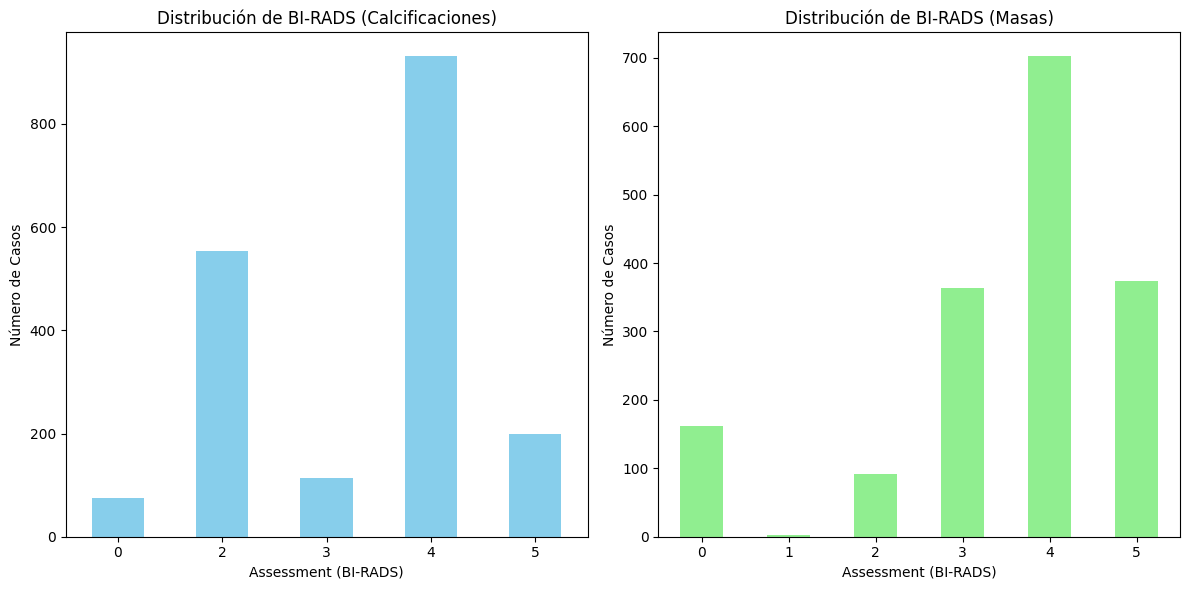

In [137]:
#Diferencia BiRads entre Calc y Mass

# Analizar distribuciones de BI-RADS (assessment) para calcificaciones y masas
calc_assessment_dist = calc['assessment'].value_counts().sort_index()
mass_assessment_dist = mass['assessment'].value_counts().sort_index()

# Visualizar distribuciones de BI-RADS
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
calc_assessment_dist.plot(kind='bar', color='skyblue')
plt.title("Distribución de BI-RADS (Calcificaciones)")
plt.xlabel("Assessment (BI-RADS)")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
mass_assessment_dist.plot(kind='bar', color='lightgreen')
plt.title("Distribución de BI-RADS (Masas)")
plt.xlabel("Assessment (BI-RADS)")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Desbalance de clases en Pathology (Calcificaciones):
pathology
MALIGNANT                  673
BENIGN                     658
BENIGN_WITHOUT_CALLBACK    541
Name: count, dtype: int64

Desbalance de clases en Pathology (Masas):
pathology
MALIGNANT                  784
BENIGN                     771
BENIGN_WITHOUT_CALLBACK    141
Name: count, dtype: int64


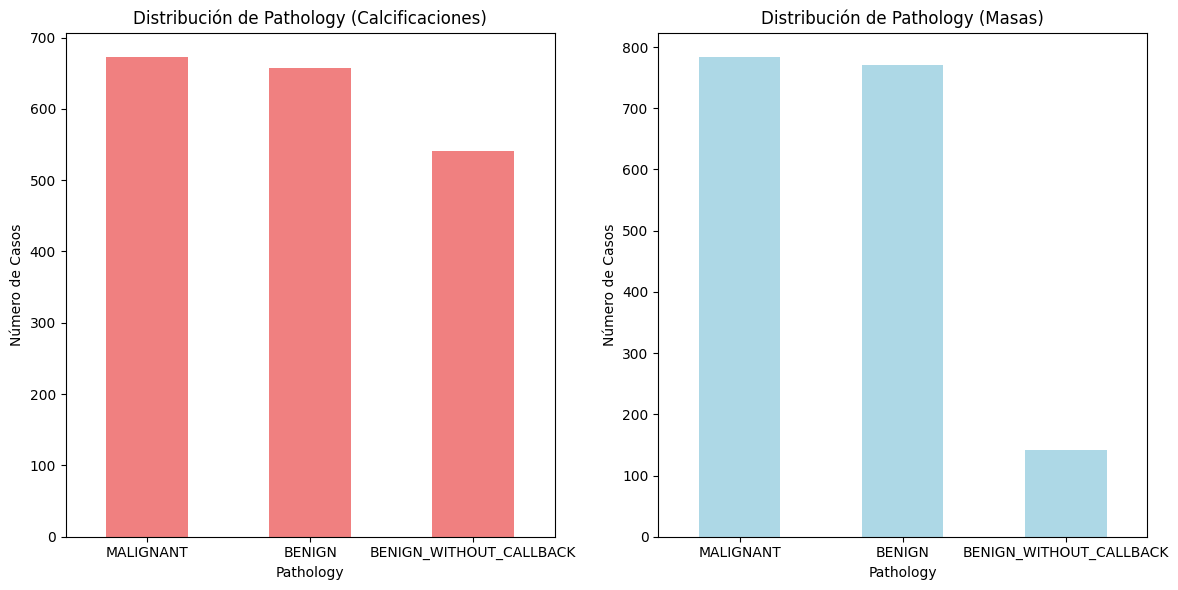

In [138]:
#Comparativa patología:

# Calcular la distribución de las clases de 'pathology' para calcificaciones y masas
calc_pathology_dist = calc['pathology'].value_counts()
mass_pathology_dist = mass['pathology'].value_counts()

# Mostrar las cifras del desbalance de clases
print("Desbalance de clases en Pathology (Calcificaciones):")
print(calc_pathology_dist)

print("\nDesbalance de clases en Pathology (Masas):")
print(mass_pathology_dist)


#visualización

# Comparar la distribución de pathology para calcificaciones y masas
calc_pathology_dist = calc['pathology'].value_counts()
mass_pathology_dist = mass['pathology'].value_counts()

# Visualizar distribuciones de pathology
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
calc_pathology_dist.plot(kind='bar', color='lightcoral')
plt.title("Distribución de Pathology (Calcificaciones)")
plt.xlabel("Pathology")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
mass_pathology_dist.plot(kind='bar', color='lightblue')
plt.title("Distribución de Pathology (Masas)")
plt.xlabel("Pathology")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


Comprobar si las imágenes existen o si están correptas

In [139]:
def find_corrupt_images(df, cols=['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']):
    corrupt_report = []

    for col in cols:
        print(f"\n🔍 Verificando columna: {col}")
        for idx, path in df[col].items():
            if not path or not os.path.exists(path):
                print(f"❌ Ruta inexistente en índice {idx}: {path}")
                corrupt_report.append((idx, col, path, 'Ruta inexistente'))
                continue

            try:
                with Image.open(path) as img:
                    img.load()
            except Exception as e:
                print(f"❌ Imagen corrupta en índice {idx}: {path} — Error: {e}")
                corrupt_report.append((idx, col, path, str(e)))

    if corrupt_report:
        print(f"\n⚠️ Se encontraron {len(corrupt_report)} errores en imágenes.")
    else:
        print("\n✅ Todas las imágenes están en buen estado.")
    
    return corrupt_report


In [140]:
corrupt_calc = find_corrupt_images(calc)
corrupt_mass = find_corrupt_images(mass)


🔍 Verificando columna: image_file_path
❌ Ruta inexistente en índice 1546: None
❌ Ruta inexistente en índice 1547: None
❌ Ruta inexistente en índice 1548: None
❌ Ruta inexistente en índice 1549: None
❌ Ruta inexistente en índice 1550: None
❌ Ruta inexistente en índice 1551: None
❌ Ruta inexistente en índice 1552: None
❌ Ruta inexistente en índice 1553: None
❌ Ruta inexistente en índice 1554: None
❌ Ruta inexistente en índice 1555: None
❌ Ruta inexistente en índice 1556: None
❌ Ruta inexistente en índice 1557: None
❌ Ruta inexistente en índice 1558: None
❌ Ruta inexistente en índice 1559: None
❌ Ruta inexistente en índice 1560: None
❌ Ruta inexistente en índice 1561: None
❌ Ruta inexistente en índice 1562: None
❌ Ruta inexistente en índice 1563: None
❌ Ruta inexistente en índice 1564: None
❌ Ruta inexistente en índice 1565: None
❌ Ruta inexistente en índice 1566: None
❌ Ruta inexistente en índice 1567: None
❌ Ruta inexistente en índice 1568: None
❌ Ruta inexistente en índice 1569: None


Faltan 606 imágenes ("None", pero las que sí tiene ruta funcionan correctamente)

In [141]:
# Ver filas con al menos una ruta vacía, nula o con "None"
missing_paths_calc = calc[calc[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].map(lambda x: pd.isnull(x) or x == "None").any(axis=1)]
missing_paths_mass = mass[mass[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].map(lambda x: pd.isnull(x) or x == "None").any(axis=1)]

print("Rutas faltantes en calc:", missing_paths_calc.shape[0])
print("Rutas faltantes en mass:", missing_paths_mass.shape[0])


Rutas faltantes en calc: 327
Rutas faltantes en mass: 0


In [142]:
# Mostrar las filas de calc donde faltan rutas
missing_paths_calc_details = missing_paths_calc[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']]

# Opcional: Mostrar las primeras filas de los resultados para revisarlas
print("Detalles de rutas faltantes en calc:")
print(missing_paths_calc_details)

Detalles de rutas faltantes en calc:
                                        image_file_path  \
344   C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...   
1216  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...   
1546                                               None   
1547                                               None   
1548                                               None   
...                                                 ...   
1867                                               None   
1868                                               None   
1869                                               None   
1870  C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/d...   
1871                                               None   

                                cropped_image_file_path roi_mask_file_path  
344                                                None               None  
1216                                               None               None  
1546  C:/Users/swatc/De

In [143]:
# Crear una columna adicional para contar los valores faltantes por fila
missing_paths_calc['missing_count'] = missing_paths_calc[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].apply(lambda row: row.isnull().sum() + (row == "None").sum(), axis=1)

# Crear la tabla resumen (pivot) con el conteo de valores faltantes por cada columna
pivot_table = missing_paths_calc[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].isnull().astype(int).sum()

# Mostrar la tabla con el número de imágenes faltantes en cada columna
print("Número de imágenes faltantes en cada columna:")
print(pivot_table)

# Crear una tabla con el número de filas que faltan 1, 2 o 3 valores
missing_count_summary = missing_paths_calc['missing_count'].value_counts().sort_index()

# Mostrar el resumen del número de filas que tienen 1, 2 o 3 valores faltantes
print("\nNúmero de filas con 1, 2 o 3 valores faltantes:")
print(missing_count_summary)


Número de imágenes faltantes en cada columna:
image_file_path            282
cropped_image_file_path      2
roi_mask_file_path         322
dtype: int64

Número de filas con 1, 2 o 3 valores faltantes:
missing_count
1     48
2    279
Name: count, dtype: int64


C:\Users\swatc\AppData\Local\Temp\ipykernel_4720\2955709705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_paths_calc['missing_count'] = missing_paths_calc[['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']].apply(lambda row: row.isnull().sum() + (row == "None").sum(), axis=1)


Eliminamos las filas en las que image_file_path está vacío, ya que si no existe esta imagen, que sería en input del modelo, no podemos usar estas líneas para entrenarlo

In [144]:
calc = calc[calc['image_file_path'].notna() & (calc['image_file_path'] != '')]
mass = mass[mass['image_file_path'].notna() & (mass['image_file_path'] != '')]

Dimensiones de imágenes

In [145]:
from PIL import Image

def check_image_sizes(df, col):
    sizes = []
    for path in df[col]:
        try:
            with Image.open(path) as img:
                sizes.append(img.size)
        except:
            sizes.append(None)
    return pd.Series(sizes).value_counts()

print(check_image_sizes(calc, 'image_file_path'))


(3096, 4600)    9
(4064, 5592)    7
(3072, 4608)    7
(3040, 4640)    7
(3008, 4352)    6
               ..
(2296, 5431)    1
(3241, 5386)    1
(3040, 4864)    1
(2856, 4888)    1
(2456, 4688)    1
Name: count, Length: 1172, dtype: int64


Como las imagenes tienen dimensiones diferentes, vamos a redimensionarlas con un factor de escala que preserve la relación de aspecto y luego hacer padding solo en los bordes si es necesario.
A nivel computacional sería mejor trabajar con 224x224, que es con el ue vamos a empezar, pero es posible que, al contener las mamografías detalles muy pequeños y específicos, quizá debemos considerar más adelante trabajar con una resolución más alta, como 512x512 o 1024x1024.

In [146]:
def resize_and_pad_and_save(image_path, output_path, target_size=(224, 224), fill_color=(255, 255, 255)): 
    #hacemos padding con color blanco, porque las imágenes tiene bordes blancos
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            aspect_ratio = width / height

            if aspect_ratio > 1:
                new_width = target_size[0]
                new_height = int(target_size[0] / aspect_ratio)
            else:
                new_height = target_size[1]
                new_width = int(target_size[1] * aspect_ratio)

            img_resized = img.resize((new_width, new_height))
            img_padded = Image.new("RGB", target_size, fill_color)
            padding_left = (target_size[0] - new_width) // 2
            padding_top = (target_size[1] - new_height) // 2
            img_padded.paste(img_resized, (padding_left, padding_top))

            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            img_padded.save(output_path)

            return output_path
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_dataframe(df, name, columns_to_process):
    for col in columns_to_process:
        new_col = f"{col}_red"
        new_paths = []
        for path in df[col]:
            if isinstance(path, str):
                output_path = os.path.join("processed_images", name, col, os.path.basename(path))
                new_path = resize_and_pad_and_save(path, output_path)
            else:
                new_path = None
            new_paths.append(new_path)
        df[new_col] = new_paths
    return df

# Aplica el procesamiento
columns = ['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']

calc = process_dataframe(calc, 'calc', columns)
mass = process_dataframe(mass, 'mass', columns)


In [147]:
def check_image_sizes(df, col):
    sizes = []
    for path in df[col]:
        try:
            with Image.open(path) as img:
                sizes.append(img.size)
        except:
            sizes.append(None)
    return pd.Series(sizes).value_counts()

print(check_image_sizes(calc, 'image_file_path_red'))

(224, 224)    1590
Name: count, dtype: int64


Eliminar duplicados

In [148]:
calc = calc.drop_duplicates(subset=['image_file_path']).reset_index(drop=True)
mass = mass.drop_duplicates(subset=['image_file_path']).reset_index(drop=True)


## Normalización de datos

Comprobar valores de los píxeles para el conjunto de imágenes

In [149]:
def check_pixel_range_multiple(dfs, columns):
    results = {}

    for df_name, df in dfs.items():
        for col in columns:
            min_vals = []
            max_vals = []

            for path in df[col].dropna():
                if path != "None":  # Evitar cadenas "None"
                    try:
                        with Image.open(path) as img:
                            img = img.convert("L")  # Escala de grises
                            arr = np.array(img)
                            min_vals.append(arr.min())
                            max_vals.append(arr.max())
                    except Exception as e:
                        print(f"❌ Error con {path}: {e}")

            if min_vals and max_vals:
                global_min = np.min(min_vals)
                global_max = np.max(max_vals)
                print(f"📊 {df_name} - {col}: Mínimo global = {global_min}, Máximo global = {global_max}")
                results[(df_name, col)] = (min_vals, max_vals)
            else:
                print(f"⚠️ {df_name} - {col}: No se encontraron valores válidos.")
                results[(df_name, col)] = ([], [])

    return results

# Uso:
dfs = {"calc": calc, "mass": mass}
columns = ['image_file_path', 'cropped_image_file_path', 'roi_mask_file_path']
results = check_pixel_range_multiple(dfs, columns)



📊 calc - image_file_path: Mínimo global = 0, Máximo global = 255
📊 calc - cropped_image_file_path: Mínimo global = 0, Máximo global = 255
📊 calc - roi_mask_file_path: Mínimo global = 0, Máximo global = 255
📊 mass - image_file_path: Mínimo global = 0, Máximo global = 255
📊 mass - cropped_image_file_path: Mínimo global = 0, Máximo global = 255
📊 mass - roi_mask_file_path: Mínimo global = 0, Máximo global = 255


In [150]:
calc.to_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/calc.csv', index=False)
mass.to_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/mass.csv', index=False)


Normalizar: Escalado a [0, 1]

In [151]:
calc = pd.read_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/calc.csv')
mass = pd.read_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/mass.csv')

In [152]:
def load_and_normalize_image(path):
    try:
        if pd.notna(path) and path != "None":
            with Image.open(path) as img:
                img = img.convert("L")  # Escala de grises
                arr = np.array(img, dtype=np.float32) / 255.0  # Normaliza a [0,1]
                return arr
    except Exception as e:
        print(f"⚠️ Error con la imagen {path}: {e}")
    return None  # Si la imagen no es válida


In [153]:
def apply_normalization(df, columns):
    for col in columns:
        print(f"🔄 Normalizando columna: {col}")
        df[f'{col}_normalized'] = df[col].apply(load_and_normalize_image)
    return df


In [154]:
columns_to_process = ['image_file_path_red']

calc = apply_normalization(calc, columns_to_process)


🔄 Normalizando columna: image_file_path_red


In [155]:
mass = apply_normalization(mass, columns_to_process)

🔄 Normalizando columna: image_file_path_red


In [156]:
print(calc['image_file_path_red'].isna().sum())  # Cuántas fallaron
print(calc['image_file_path_red'].head())        # Revisa cómo quedaron


0
0    processed_images\calc\image_file_path\1-188.jpg
1    processed_images\calc\image_file_path\1-189.jpg
2    processed_images\calc\image_file_path\1-190.jpg
3    processed_images\calc\image_file_path\1-191.jpg
4    processed_images\calc\image_file_path\1-192.jpg
Name: image_file_path_red, dtype: object


In [157]:
len (calc)

1265

In [158]:
len(mass)

1592

In [159]:
calc.to_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/calc.csv', index=False)

In [160]:

mass.to_csv('C:/Users/swatc/Desktop/UNI/TFM/TFM/artifacts/data/mass.csv', index=False)